# Titanic: Machine Learning from Disaster

My goal in the notebook was to play around with genetic programming (gplearn) and especially H20 Framework and compare the results obtains between sklearn and H20. Even those, I have a descent score on Kaggle, I did not use complicated nor advance features transformation and; I believe, if I would like to improve my score, I would have to spend more time features engineering – which was not the principal object.

### Data understanding
- 1)  Understand Target: understand the target distribution and what type of problem it is
- 2) Features preparation: merge training and test for a faster features engineering 

### Features engineering
- 1) hunting NaNs: find missing values and replace or discard them
- 2) Outlier Detection: find outlier in the dataset
- 3) Skewness: apply log transformation to some numerical features to approximate gaussian distribution

### Dimensionality reduction
Reduce high-dimensional features to a lower level by merging “similar” levels together

### Features Creation
Using Genetic programming (gplean) to generate new combination of features

### Modelling

- 1) Base model: Random Forest
- 2) Element Ensemble: Voting Classifier

## H20 Framework
- 1) Transform Pandas data frame to H20 data frame
- 2) h2o single model – GBM
- 3) h2o single model RF
- 4) h2o Stacking with metalearner
- 5) Out of sample submission

### Conclusion
Quick explanation of the results of some of my models and few points on further improvement

**Best out of sample score: 0.798 - Top 12% as of April 2018**

**Main sources**

- [Kaggle, Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- [H20 main page](https://www.h2o.ai/)
- [Genetic Programming: gplearn](http://gplearn.readthedocs.io/en/stable/intro.html)

### Author: Cedric Viret

#### Basic Library

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline
from scipy.stats import skew

pd.set_option("max_columns", None)

#### Loading Data

In [122]:
path = "input/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

#### Glimpse of the data

In [123]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data understanding

#### Understand Target

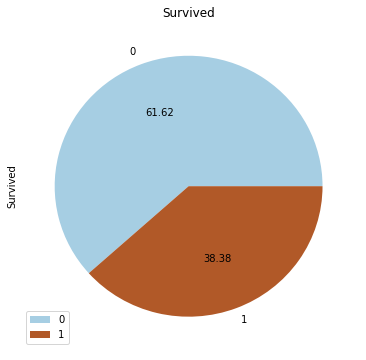

In [124]:
#understand target
train.groupby("Survived")["Survived"].count().plot.pie(figsize=(6,6), autopct='%.2f', legend=True, title="Survived",colormap ="Paired")

#understand target data by gender


**It is a balance binary classification problem**

### Features preparation
- Drop the target column and assign it to y_train
- Merge train and test set (it avoids doing double transformation on train and test set)



In [125]:
#y_train
y_train = train["Survived"]

#drop target form training
train = train.drop("Survived", inplace = False, axis = 1)

#concat training and testing
features = pd.concat([train, test]).reset_index(drop=True)

#store training and testing shape
train_shape = train.shape
test_shape = test.shape
y_train_shape = y_train.shape

#saving the test index
test_id = test.PassengerId

print("train shape", train_shape)
print("test shape", test_shape)
print("y_train", y_train_shape)

#making sure features have the same lenght as combine train and test
if (features.shape[0]-(train_shape[0]+test_shape[0]))==0:
    print("All good-total amount of rows:", features.shape[0])
else:
    print("something went wrong!")


train shape (891, 11)
test shape (418, 11)
y_train (891,)
All good-total amount of rows: 1309


Analysis the features (excluding the target):
- understand the type of features
- if we can drop some features because they are unique (especially  thinking about “PassengerId” and “Tickets”)


In [126]:
features.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [127]:
#amount of unique values per columns and columns name
values = [len(features.loc[:,serie].unique()) for serie in features.columns]
index = [name for name in features.columns]

#create a DataFrame
df_unique=pd.DataFrame(values, index=index, columns=["amt_unique"]).sort_values("amt_unique", ascending=False)

#append column unique
df_unique["unique"] = df_unique.amt_unique.apply(lambda x: "unique" if x == features.shape[0] else "not unique")

df_unique

,amt_unique,unique
PassengerId,1309,unique
Name,1307,not unique
Ticket,929,not unique
Fare,282,not unique
Cabin,187,not unique
Age,99,not unique
Parch,8,not unique
SibSp,7,not unique
Embarked,4,not unique
Pclass,3,not unique


Looking at the results of the data frame we can easily see that “PassengerId” is unique, so it can be removed and so as Name (almost unique). Moreover, the name of a passenger should not tell if one survives or not.

In [128]:
features.drop(["PassengerId", "Name"], inplace = True, axis = 1)
print("Features dropped, so columns is of:",features.shape[1])

Features dropped, so columns is of: 9


### Features engineering
- hunting NaNs
- preform some NaNs imputation
- outlier detections
- transform some skewed numerical features
- dimensionality reduction (not using PCA or LDA)


In [129]:
#print missing value pre features
def is_null(serie):
    if features.loc[:,serie].isnull().sum() >0:
        print(serie,"has some missing values:", features.loc[:,serie].isnull().sum())
    else:
        print(serie,"no missing values")

#### hunting NaNs<br>
Understand the missing value distribution into the data set.


In [130]:
values_na = [len(features[features.loc[:,serie].isnull()==True]) for serie in features.columns]
index = [name for name in features.columns]

#create a DataFrame
df_na=pd.DataFrame(values_na, index=index, columns=["amt_na"]).sort_values("amt_na", ascending=False)

df_na

,amt_na
Cabin,1014
Age,263
Embarked,2
Fare,1
Pclass,0
Sex,0
SibSp,0
Parch,0
Ticket,0


##### NaNs imputation for Embarked and Fare

In [131]:
#Embarked and Fare Understanding
print(features[features.Embarked.isnull() == True])
print(features[features.Fare.isnull() == True])


     Pclass     Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked
61        1  female  38.0      0      0  113572  80.0   B28      NaN
829       1  female  62.0      0      0  113572  80.0   B28      NaN
      Pclass   Sex   Age  SibSp  Parch Ticket  Fare Cabin Embarked
1043       3  male  60.5      0      0   3701   NaN   NaN        S


Let's focus first on Embarket:<br>
**Ticket number are the same for both passenger- so it make sense to impute the same "Embarked" value for both**.

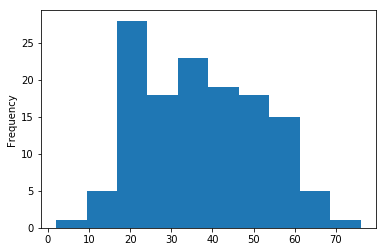

In [132]:
features[(features["Sex"]=="female") & (features["Pclass"]==1)]["Age"].plot.hist()

The age distribution of the female in first class does not tell us a lot about which "Embarked" letter we should impute... So let ‘see from which Embarked the first class passenger come from:

In [133]:
features[(features["Pclass"]==1) & (features["Sex"]=="female")].groupby("Embarked")["Embarked"].count()


Embarked
C    71
Q     2
S    69
Name: Embarked, dtype: int64

We still don't have a lot of more info, I decide to impute the "Embarked" missing values by "S".
**Reason: if look at the neighbour cabin from B28, most of the passenger come from "Southampton" (S) - hence I will impute "S"**


In [134]:
features.Embarked.fillna("S", inplace = True)

Now on focusing on "Fare":<br>
NaN imputation with the median of the male in first class 

In [135]:
#replace Fare with the median of male in class 3 coming for S
fare_replace = features[(features["Pclass"]==1) & (features["Sex"]=="male") & (features["Embarked"]=="S")]["Fare"].median()
features.Fare.fillna(fare_replace, inplace = True)


#### NaNs Imputation for "Cabin"
Replacing missing values by “X”


In [136]:
#replace Cabin by "X"
features.Cabin.fillna("X", inplace = True)

#### Age imputation
I will impute the NaNs for Age base on similar (complete) row according to “Pclass”, “Parch” and “SibSp”.
Function take from:https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling


In [137]:
## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(features["Age"][features["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = features["Age"].median()
    age_pred = features["Age"][((features['SibSp'] == features.iloc[i]["SibSp"]) & (features['Parch'] == features.iloc[i]["Parch"]) & (features['Pclass'] == features.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        features['Age'].iloc[i] = age_pred
    else :
        features['Age'].iloc[i] = age_med

C:\Users\viret\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [138]:
#Check remaining missing values:
for col in features.columns:
    is_null(col)

Pclass no missing values
Sex no missing values
Age no missing values
SibSp no missing values
Parch no missing values
Ticket no missing values
Fare no missing values
Cabin no missing values
Embarked no missing values


#### Outlier Detection

In [139]:
features.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,29.179656,0.498854,0.385027,33.297163
std,0.837836,13.269138,1.041658,0.865560,51.738915
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800
50%,3.000000,26.000000,0.000000,0.000000,14.454200
75%,3.000000,37.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


It does not seem that some values are totally out of range BUT “Fare” seem to be skewed


#### Skewness

Fare skewness in value: 4.36926776234


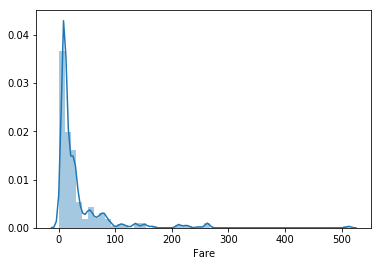

In [140]:
#plot skew
sns.distplot(features["Fare"])

#skew in values
print("Fare skewness in value:",features["Fare"].skew())



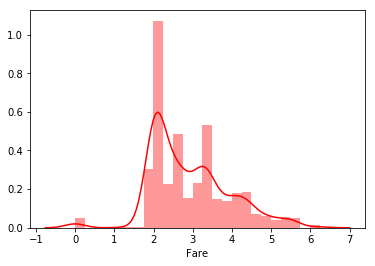

In [141]:
features["Fare"] = features["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

#plot skew
sns.distplot(features["Fare"], color= "r")

### Dimensionality reduction<br>
"Cabin" has a lot of dimensions - I will reduce then by only considering the letter of the cabin and not the number


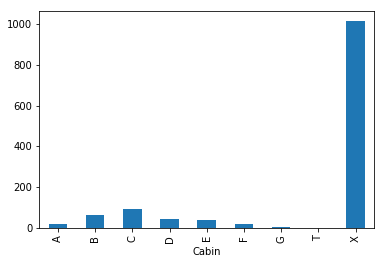

In [142]:
#Reduce the Cabin dimension to it first letter
features["Cabin"] = features.Cabin.apply(lambda x: x[0])

#quick view of the remaining levels
features.groupby("Cabin")["Cabin"].count().plot.bar()

"ticket" also have a lot of dimensions, so I will reduce them by only considering the letter of the ticket (without the "." or "/" ) - for the numerical ticket such as "11129292" I will replace them by the letter "W"

In [143]:
#clean ticket of . and /
ticket_clean = [i.replace(".","").replace("/","").strip().split(' ')[0] if not i.isdigit() else "W" for i in list(features.Ticket)]

#append to ticket
features["Ticket"] = ticket_clean

#reduce the level even more
a_val = ['A', 'A4', 'A5','AQ3', 'AQ4', 'AS']
c_val = ['C', 'CA', 'CASOTON']
f_val = ['FC', 'FCC','Fa']
l_val = ['LP','LINE']
p_val = ['PC','PP','PPP']
s_val = ['SC','SCA3','SCA4','SCAH', 'SCOW', 'SCPARIS', 'SCParis'] #s0
s_val1 = ['SOC','SOP','SOPP','SP'] #s1
s_val2 = ['SOTONO2','SOTONOQ','STONO','STONO2','STONOQ']
w_val = ['WC','WEP'] #set as WW

#V
val = [a_val,c_val,f_val, l_val, p_val, s_val,s_val1,s_val2,w_val]
tag = ['A','C','F','L','P','S0','S1','S2','WW']

for val, tag in zip(val,tag):
                    features.Ticket.replace(val, tag, inplace = True)


In [144]:
#show remaining dimensions
features.groupby("Ticket")["Ticket"].count()

Ticket
A        42
C        77
F        13
L         5
P        98
S0       30
S1       17
S2       49
SWPP      2
W       957
WW       19
Name: Ticket, dtype: int64

Tansforming "Pclass" into categorical feature

In [145]:
#changing Pclass type
features["Pclass"] = features["Pclass"].astype("str")


#### Encoding

In [146]:
#copy before encoding
features_copy = features.copy()

#Enoding
features = pd.get_dummies(features)

#saving features columns name
features_col = features.columns

#shape
features.shape

(1309, 32)

In [147]:
features.head()


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_A,Ticket_C,Ticket_F,Ticket_L,Ticket_P,Ticket_S0,Ticket_S1,Ticket_S2,Ticket_SWPP,Ticket_W,Ticket_WW,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,1.981001,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,1,0,4.266662,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,26.0,0,0,2.070022,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,1,0,3.972177,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,35.0,0,0,2.085672,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


#### Checking dummy columns <br>
After creating dummy, I check if some features contain to many “0”. If yes, I will remove then to avoid adding “noise” into the data.

**Reason: if a feature is compose of 99.9% of 0, it has no information power but add noise; therefor it can be remove.**


In [148]:
def zero_amt(serie, thresold):
    serie_one = features.groupby(serie)[serie].count()[1]/features.groupby(serie)[serie].count()[0] * 100
    if serie_one < thresold:
        print(serie, serie_one)
        
#loop with zerop_amt function
thresold = 0.5 #in %
for serie in features.columns[4:34]:  #loop thought the categorical features
    zero_amt(serie, thresold = thresold)



Ticket_L 0.383435582822
Ticket_SWPP 0.153022188217
Cabin_G 0.383435582822
Cabin_T 0.0764525993884


In [149]:
#dropping columns
features.drop(['Ticket_L', 'Ticket_SWPP','Cabin_G','Cabin_T'], inplace = True, axis = 1)
features.shape

(1309, 28)

#### Train and testing (for gplearn

In [150]:
X_train = features.iloc[:train_shape[0],:]
X_test = features.iloc[train_shape[0]:,:]

### Features Creation

#### Genetic Programming with [gplearn](https://gplearn.readthedocs.io/en/stable/examples.html?highlight=hall_of_fame%20)<br>
Generating 20 news features that are non-linear combinations of the existing features. By taking the least correlated features (here 20) and append them with the existing features, it “augments” the dataset. This augmentation might give a better representation of the data and, potentially increases the predicting power of some algorithms.

Note: I will use tree-based methods or gradient boosting methods as main family of algorithms. Therefore, even if, the newly created features do not help at solving the classification tasks, it will have no impact on the results, since this “families of algorithm” preform features selection.



In [151]:
from gplearn.genetic import SymbolicTransformer

# possible ways of combining features for algorithm
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min', 'sin', 'cos', 'tan']

#setting up the genetic algorithm
gp = SymbolicTransformer(generations=20,        #number of generation to evolve
                         population_size=2000,
                         hall_of_fame=100,
                         n_components=20,      #number of best "hall of fame" to be return (least correlated)
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         verbose=10,
                         random_state=42,
                         n_jobs=3,
                         metric = 'spearman')

#gp fit
gp_fit = gp.fit(X_train, y_train)

#Transform features
gp_transform = gp_fit.transform(features)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


   0     8.22   0.130786054513        3   0.578600006812   0.548855549135     48.77s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


   1      7.4   0.394261820151       11   0.601270978114   0.670688898806     48.98s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


   2     4.76   0.486446431222       10   0.618084118021   0.526701537212     50.00s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


   3     6.37   0.482232606034        5   0.630861287054   0.245928797347     48.91s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished


   4     7.77   0.499143810001       12   0.640773716152   0.348849550653     48.44s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


   5     10.3   0.515045006228       16   0.634433222261   0.428441604951     48.00s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.9s finished


   6    13.11   0.527748074193       17   0.638797672719   0.511167976764     46.06s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


   7    13.51   0.528526636256       15    0.64221948904    0.51928293368     44.53s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished


   8    14.34   0.542472699117       22   0.654701961336   0.355905824343     40.53s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


   9    16.48   0.558058393742       35   0.649663241006   0.415493884551     38.33s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished


  10    18.07   0.573869950857       20   0.654884075136   0.386724912634     34.56s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s finished


  11    17.45   0.570943758842       20   0.657264833313   0.416798175079     30.54s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


  12    17.28   0.574314924473        9   0.657211365034   0.381418820684     27.08s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.6s finished


  13    17.42   0.576535501737       36   0.666747688863   0.314353987809     23.30s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.4s finished


  14    17.07     0.5805371757       11   0.657332779889   0.372115807165     19.40s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.8s finished


  15    17.37   0.580410262882       47   0.657218006357   0.434615716192     15.63s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished


  16    16.36   0.581368123375       31   0.654425223075   0.464680899156     11.74s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished


  17    16.67   0.588655412584       22   0.661340490055   0.409460154706      7.81s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.7s finished


  18    16.49   0.586540614797       23   0.659109678362   0.458772344919      3.91s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished


  19    16.65   0.584217177239       25   0.658094345705   0.427935055515      0.00s


In [152]:
#Create a DataFrame
df_gp = pd.DataFrame(gp_transform)  #create a dataframe
df_gp.columns = ['gp_set_' + str(col) for col in df_gp.columns] #assign column name
df_gp.index = features.index  #assign index of the features

#Concate feature and gp DataFrame
features = pd.concat([features, df_gp], axis = 1)

features.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_A,Ticket_C,Ticket_F,Ticket_P,Ticket_S0,Ticket_S1,Ticket_S2,Ticket_W,Ticket_WW,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,gp_set_0,gp_set_1,gp_set_2,gp_set_3,gp_set_4,gp_set_5,gp_set_6,gp_set_7,gp_set_8,gp_set_9,gp_set_10,gp_set_11,gp_set_12,gp_set_13,gp_set_14,gp_set_15,gp_set_16,gp_set_17,gp_set_18,gp_set_19
0,22.0,1,0,1.981001,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4.0,5.0,2.0,4.0,4.0,6.0,4.0,6.0,3.0,4.0,5.0,6.0,2.000000,3.0,6.0,5.0,7.0,3.0,7.0,6.0
1,38.0,1,0,4.266662,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,1.0,1.0,-1.0,1.0,0.0,0.0
2,26.0,0,0,2.070022,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,2.0,3.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,0.841471,1.0,3.0,2.0,1.0,2.0,3.0,3.0
3,35.0,1,0,3.972177,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,1.0,1.0,-1.0,1.0,0.0,0.0
4,35.0,0,0,2.085672,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,4.0,5.0,2.0,4.0,4.0,6.0,4.0,6.0,3.0,4.0,5.0,6.0,2.000000,3.0,6.0,5.0,7.0,3.0,7.0,6.0


In [153]:
#splitting again the features
X_train = features.iloc[:train_shape[0],:]
X_test = features.iloc[train_shape[0]:,:]

## Modelling

#### Modelling Libraries

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC

#### Kfold and Cross Val

In [155]:
#kfold
kfold = KFold(n_splits=3, shuffle=False, random_state=42)

#Cross val function
def classification_crossvalscore(model, x, y):
    acc = cross_val_score(model, x, y, scoring = 'accuracy', cv = kfold)
    return acc


### Base model-RF (no GridSearch)

In [156]:
#model-RF
rf = RandomForestClassifier()

#Model fit
#RF_fit=RF.fit(X_train,y_train)


#### In Sampe Scoring

In [157]:
cross_val_score(rf, X_train, y_train).mean()

0.79685746352413023

### Voting Classifier-Sklearn

In [158]:
#GBM
model1 = GradientBoostingClassifier(criterion='friedman_mse',
                                    learning_rate= 1, 
                                    loss= 'deviance',
                                    max_depth= 100, 
                                    n_estimators= 100)

#XGBoost
model2 = XGBClassifier(booster='gbtree',
                       gamma= 0.4, 
                       learning_rate= 0.01,
                       max_depth= 10,
                       n_estimators= 350, 
                       objective= 'binary:logistic')

#model2 = model2.fit(X_train,y_train)

#Random Forest
model3 = RandomForestClassifier(criterion= 'gini',
                                max_depth = 100,
                                max_features = None,
                                n_estimators= 600)


#lightGBM
model4 = LGBMClassifier(boosting_type = 'dart',
                        learning_rate = 0.01,
                        max_depth = -1,
                        n_estimators = 1000,
                        num_leaves = 31)

#SVM
model5 = SVC(C= 50,
             gamma= 0.001,
             kernel= 'rbf',
             probability=True)


In [159]:
#Create model Framework
cf1 = model1
cf2 = model2
cf3 = model3
cf4 = model4
cf5 = model5

#list of estimator with names
estimators = [('gbm', cf1),('xgb', cf2),('rf', cf3), ('lgbm', cf4), ('svm', cf4)]

#Voting Classifier
ecf = VotingClassifier(estimators= estimators,
                          voting='soft',            #soft for probability
                          weights=[0,2,0,2,4],
                          n_jobs=1,
                          flatten_transform=None)

#Display Voting Classifier score
for clf, label in zip([cf1, cf2,cf3,cf4,cf5, ecf], ['gbm', 'xgb', 'rf','lgbm','svm','Voting Classifier']):
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    print(label, scores)

#Voting Classifier fit
vc = ecf.fit(X_train, y_train)

#Voting Classifier predict
#vc.predict(X_test)

gbm 0.810325476992
xgb 0.826038159371
rf 0.810325476992
lgbm 0.821548821549
svm 0.837261503928
Voting Classifier 0.830527497194


In [160]:
#Sklearn submission
#submission = pd.DataFrame()
#submission['PassengerId'] = test_id
#submission['Survived'] = prediction
#submission.to_csv("sklearn_sub",index = False)

## [H20](https://www.h2o.ai/) Framework

##### Connect to H20

In [161]:
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o
h2o.init(ip="localhost", port=54323)

#libaries
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
#from h2o.estimators import H2OXGBoostEstimator does not work on windows ;( 

from h2o.grid.grid_search import H2OGridSearch

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O cluster uptime:,1 hour 2 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_viret_kgwe4d
H2O cluster total nodes:,1
H2O cluster free memory:,1.553 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


##### Transform Panda Dataframe to H20 dataframe

In [162]:
#create a df for the features
features =X_train
test = X_test #need string as column name
#append traget
features["Survived"]=y_train

#h2o dataframe
h20_features = h2o.H2OFrame(X_train)
h20_test = h2o.H2OFrame(X_test)

#display h2o dataframe
h20_features

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_A,Ticket_C,Ticket_F,Ticket_P,Ticket_S0,Ticket_S1,Ticket_S2,Ticket_W,Ticket_WW,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,gp_set_0,gp_set_1,gp_set_2,gp_set_3,gp_set_4,gp_set_5,gp_set_6,gp_set_7,gp_set_8,gp_set_9,gp_set_10,gp_set_11,gp_set_12,gp_set_13,gp_set_14,gp_set_15,gp_set_16,gp_set_17,gp_set_18,gp_set_19,Survived
22,1,0,1.981,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4,5,2,4,4,6,4,6,3,4,5,6,2,3,6,5,7,3,7,6,0
38,1,0,4.26666,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,-1,0,0,0,0,0,0,1,1,0,0,0,1,1,-1,1,0,0,1
26,0,0,2.07002,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,2,3,1,1,2,3,2,2,2,2,3,2,0.841471,1,3,2,1,2,3,3,1
35,1,0,3.97218,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,-1,0,0,0,0,0,0,1,1,0,0,0,1,1,-1,1,0,0,1
35,0,0,2.08567,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,4,5,2,4,4,6,4,6,3,4,5,6,2,3,6,5,7,3,7,6,0
25,0,0,2.13515,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,4,5,2,4,4,6,4,6,3,4,5,6,2,3,6,5,7,3,7,6,0
54,0,0,3.9486,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,2,2,1,3,3,3,2,4,2,2,3,4,1,2,3,4,5,2,4,3,0
2,3,1,3.04809,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,3,2,3,2,3,0
27,0,2,2.40994,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2,3,1,1,2,3,2,2,2,2,3,2,0.841471,1,3,2,1,2,3,3,1
14,1,0,3.40355,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,0,0,0,1,0,0,1,2,0,0,0,1,1,-1,1,0,0,1


##### Set up trarget and cross val folds

In [163]:
x = list(features.columns) #need to be a list of values
y = "Survived" 
#x.remove(y)
# For binary classification, response should be a factor
h20_features["Survived"] = h20_features["Survived"].asfactor()

#fold for cross val
nfolds = 3

#### h2o single model - GBM

In [165]:
#hyper_paramters
hyper_params = {'learn_rate': [0.01, 0.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0],
                'ntrees': [20, 50, 80, 110, 140, 170, 200]
               }

#search_criteria
search_criteria = {"strategy": "RandomDiscrete", "max_models": 45, "seed": 1}

# Train the grid
grid_GBM = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=1,
                                                            nfolds=nfolds,
                                                            fold_assignment="Modulo",
                                                            keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_final")

#model fit
grid_GBM.train(x=x, y=y, training_frame=h20_features)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


#### h2o single model RF

In [166]:
#hyper_paramters
hyper_params = { 'balance_classes': [True, False],
                'max_after_balance_size': [.85, 1.7,.5],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'ntrees': [20, 50, 80, 110, 140, 170, 200]
               # 'col_sample_rate': [0.2, 0.5, 1.0]
               }

#search_criteria
search_criteria = {"strategy": "RandomDiscrete", "max_models": 45, "seed": 1}

#search_criteria
grid_RF = H2OGridSearch(model=H2ORandomForestEstimator(seed=1,
                                                       nfolds=nfolds,
                                                       fold_assignment="Modulo",
                                                       keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="drf_final")
#model fit
grid_RF.train(x=x, y=y, training_frame=h20_features)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


#### Models with best parameters

In [167]:
#GBM
best_GBM = grid_GBM.get_grid(sort_by='accuracy', decreasing=True)[0]
#RF
best_RF = grid_RF.get_grid(sort_by='accuracy', decreasing=True)[0]


In [168]:
#print report of best Random Forest
print('Confusion matrix Random Forest\n', best_RF.confusion_matrix(metrics='accuracy'))
print('Random Forest accuracy:', best_RF.accuracy()[0][1])
print("---------------------------------------------------------")
print('Confusion matrix Gradient Boosting Methods:\n', best_GBM.confusion_matrix(metrics='accuracy'))
print('Gradient Boosting Methods accuracy:', best_GBM.accuracy()[0][1])


Confusion matrix Random Forest
 Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.46559040233958404: 


,0,1,Error,Rate
0,203.0,16.0,0.0731,(16.0/219.0)
1,62.0,153.0,0.2884,(62.0/215.0)
Total,265.0,169.0,0.1797,(78.0/434.0)



Random Forest accuracy: 0.8202764976958525
---------------------------------------------------------
Confusion matrix Gradient Boosting Methods:
 Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.4712919962434185: 


,0,1,Error,Rate
0,511.0,38.0,0.0692,(38.0/549.0)
1,67.0,275.0,0.1959,(67.0/342.0)
Total,578.0,313.0,0.1178,(105.0/891.0)



Gradient Boosting Methods accuracy: 0.8821548821548821


#### h2o Stacking with metalearner

In [169]:
#Metalearner params for gbm, drf, glm, and deep deeplearning
gbm_param = {'ntrees': [100], 'max_depth':[5]}

#create stacking with metalearner
ensemble = H2OStackedEnsembleEstimator(model_id="meta_gbm",
                                       base_models=[best_GBM,best_RF],
                                       metalearner_algorithm="gbm", metalearner_nfolds=3,
                                       metalearner_params = gbm_param)
#ensemble fit
ensemble.train(x=x, y=y, training_frame=h20_features)

#ensemble prediction
pred = ensemble.predict(h20_test)

stackedensemble Model Build progress: |███████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [170]:
print('Confusion matrix Ensemble\n', ensemble.confusion_matrix(metrics='accuracy'))
print('Gradient Boosting Methods accuracy:',ensemble.accuracy()[0][1])

Confusion matrix Ensemble
 Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.5360115974079868: 


,0,1,Error,Rate
0,502.0,47.0,0.0856,(47.0/549.0)
1,92.0,250.0,0.269,(92.0/342.0)
Total,594.0,297.0,0.156,(139.0/891.0)



Gradient Boosting Methods accuracy: 0.8439955106621774


In [179]:
pred = ensemble.predict(h20_test)


stackedensemble prediction progress: |████████████████████████████████████| 100%


#### Submission

In [178]:
#h2o submission
submission = pd.DataFrame()
submission['PassengerId'] = test_id
submission['Survived'] = h2o.as_list(pred[0]) #transform to a list the binary class

submission.to_csv("h2o_sub",index = False)

### Conclusion

My best out of sample score comes from the H20 gradient boosting method, which is also the high in sample score of all my models (0.88). The H2O stack model of Random Forest and Gradient Boosting Methods has a lower score than the Voting Classifier of Sklearn, most probably since H2O Random Forest does not perform well on the dataset.

Unfortunately, H2O Framework does not provide more algorithms such as Xgboost or LightGBM in python. Hopefully, it will change in the coming times because H2O is easy to use and the grid search are way fast that in Sklearn (run on Amazon S3 cloud). In addition, it seems that for single algorithm it gives better results – most probability due to different implementation between H2O and Sklearn.

It is also interesting to see that in H20, it is possible to implement a simple feed forward neural network as a metalearner.

### Further improvement

It is a relatively small and handy dataset, I believe to improve my score, I should try different features engineering techniques and/or try to find other data sources that could help increasing the predication accuracy.

Another possibility could be to create some “voting rules” for the best algorithms and create a ranking hierarchy (or another stack models) on top of the voting rules to convert the weak learners into strong learners.

However, as mentioned at the beginning of the notebook, my goal was to play around with some features creation using genetic programming and especially experience a new framework (H2O) for machine learning).


## Ad hoc - gridsearch

In [39]:
def grid_search(model, para):
    #grid search
    grid_search = GridSearchCV(estimator=model,
                                param_grid=para,
                                scoring='accuracy',
                                fit_params=None,
                                n_jobs=4, iid=True,
                                refit=True,
                                cv=kfold,
                                verbose=5,
                                pre_dispatch='2*n_jobs',
                                error_score='raise',
                                return_train_score='warn')


    #GridSearch fit
    grid_search.fit(X_train,y_train)
    
    #Best GridSearch Paramters
    print(grid_search.best_params_)
    

In [42]:
#Random Forest
rf = RandomForestClassifier()

para_rf =  {'n_estimators':[100,300, 600, 1000],
         'criterion':['gini'],
         'max_depth':[None, 100, 300],              
         'max_features':['auto', 'log2', None]
        }

#XGboost
xgb = XGBClassifier()

para_xgb = {'max_depth':[3,10, 100],
            'learning_rate':[0.01, 1, 0.2,0.4, 0.8, 0.9, 1.0], #= "eta"
            'n_estimators':[100,350],
            'objective':['binary:logistic'],  
            'booster':['gbtree'],
            'gamma':[0,0.1,0.4,1],      

            }
#SVM
svm = SVC()

para_svm ={'kernel': ['rbf'],
            'gamma': [ 0.001, 0.01, 0.1, 1],
            'C': [1, 10, 50, 100,200,300, 1000]}

#LightGBM
lgbm = LGBMClassifier()

para_lgbm = {'boosting_type':['gbdt', 'dart'],
            'num_leaves':[31, 50, 80],
             #'tree_learner':['serial', 'feature', 'data', 'voting']
            'max_depth':[-1,50,100,150],
            'learning_rate':[0.01, 1, 0.2,0.4, 0.8, 0.9, 1.0],
            'n_estimators':[100,300, 600, 1000]
            }

#GradientBoosting
gbm = GradientBoostingClassifier()

para_gbm =  {'loss':['deviance', 'exponential'], # first two for Classification - last four for Regression
             'learning_rate':[0.01, 1, 0.2,0.4, 0.8, 0.9, 1.0],
             'n_estimators':[100,300, 600, 1000],
             'criterion':['friedman_mse'],
             'max_depth':[None, 100]
            }

In [724]:
#Random forest
grid_search(rf,para_rf )

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  1.0min finished


{'criterion': 'gini', 'max_depth': 100, 'max_features': None, 'n_estimators': 600}


In [725]:
#light Gbm
grid_search(lgbm,para_lgbm )

Fitting 3 folds for each of 672 candidates, totalling 2016 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done 2016 out of 2016 | elapsed: 17.5min finished


{'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 31}


In [726]:
#XGB
grid_search(xgb, para_xgb)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 504 out of 504 | elapsed:  2.2min finished


{'booster': 'gbtree', 'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 350, 'objective': 'binary:logistic'}


In [ ]:
#gbm
grid_search(gbm,para_gbm )

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:  8.7min finished


{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'deviance', 'max_depth': 100, 'n_estimators': 100}


In [43]:
#SVM with pipeline

#grid
grid =GridSearchCV(estimator=svm,
                                param_grid=para_svm,
                                scoring='accuracy',
                                fit_params=None,
                                n_jobs=4, iid=True,
                                refit=True,
                                cv=kfold,
                                verbose=5,
                                pre_dispatch='4*n_jobs',
                                error_score='raise',
                                return_train_score='warn')


#GridSearch fit
grid.fit(X_train,y_train)

#Best GridSearch Paramters
print(grid.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    7.2s


{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:    8.1s finished
